<a href="https://colab.research.google.com/github/Walberf17/Walberf17/blob/main/8_queens_Integer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorith to solve the N-queens problem

## The problem

In a NxN ChessBoard, N queens will be set, but in a way that one can't attack another.

This uses a integer codification.

The ChessBoard is always NxN for N queens, where N is a Integer number, higher then zero.

This is a population algorithm.

## Imports

In [285]:
# For the solution
from random import random , sample , randrange, choice, shuffle
from statistics import mean , harmonic_mean
import numpy as np

# For showning results
import matplotlib.pyplot as plt

In [286]:
class Evolution:
    def __init__(self, n_size = 8, pop_size = 100, mutation_chance = .03, 
                 reprodution_chance = .8, max_generations = 100, 
                 generations_with_same_fitness = 100):
        self.n_size = n_size
        self.pop_size = pop_size
        self.population = list()
        self.fit_ticks = 0
        self.generation = -1
        self.generations_with_same_fitness = -1
        self.max_generations_with_same_fitness = generations_with_same_fitness
        self.create_population()
        self.mutation_chance = mutation_chance
        self.reprodution_chance = reprodution_chance
        self.parents = list()
        self.children = list()
        self.mutants = list()
        self.best_fitness_list = list()
        self.best_fitness = float('inf')
        self.max_generations = max_generations
        self.set_next_generation()
        
    def set_next_generation(self):
        """
        Reset the lists and select the next best population with the same size 
        as the initial one.
        """
        # counters
        self.generations_with_same_fitness += 1
        self.generation += 1
        
        # children
        self.population.extend(self.children)
        self.children.clear()

        # mutants
        self.population.extend(self.mutants)
        self.mutants.clear()

        # select the population
        self.population.sort(reverse = False , key = self.take_fitness)
        self.population = self.population[:self.pop_size]

        # set the metrics
        _ , best_fitness = self.population[0]
        self.best_fitness_list.append(best_fitness)
        if best_fitness < self.best_fitness:
            self.best_fitness = best_fitness
            self.generations_with_same_fitness = 0

    def take_fitness(self, individual):
        """
        Function to organize the elements in the population
        """
        return individual[1]

    def create_population(self, pop_size = None):
        """
        Create the initial population for thi object with that many individuals.
        If pop_size is None, then the initial pop_size is used.
        """
        if pop_size is None:
            pop_size = self.pop_size
        for _ in range(pop_size):
            individual = self.create_n()
            while individual in self.population:
                individual = self.create_n()
            self.population.append(individual)

    def create_n(self):
        """
        Create a individual for the population.
        The individual is a list with the dna and fitness.
        """
        individual = []
        dna = list(range(self.n_size))
        shuffle(dna)
        individual.append(dna)
        individual.append(self.calc_fit(dna))
        return individual

    def calc_fit(self, individual):
        """
        the sample is a list of ints, from 0 to N. Return a float with the value for the fit of
        this sample

        param n : list of bits, the sample
        return : int
        """
        self.fit_ticks += 1

        m_diags = set() # diagonais principais
        s_diags = set() # diagonais secundárias
        len_ind = len(individual)
        for idx , pos in enumerate(individual):
            m_diags.add(pos - idx)
            s_diags.add(idx + pos)
        
        fitness = 0
        fitness += abs(len_ind - len(m_diags))
        fitness += abs(len_ind - len(s_diags))

        return fitness

    def print_board(self, individual = None):
        """
        Print the individual if any given, or the best individual of this generation
        """
        if individual is None:
            individual = self.population[0]
        board , fit = individual
        sample_size = [len(board)]*2
        b = np.zeros(sample_size)
        a = np.full_like(b, '_' , dtype='object')
        for i, j in enumerate(board):
            a[i][j]='Q'
        for row in a:
            print(row)

    def selector(self):
        """
        Championish.

        Loop throught the population and make a competition between that individual
        and another random one. The winner is selected as a parent.

        param pop : list of lists with the population.
        param fit : func with the fit to use
        """
        parents = []
        self.population.sort(reverse = False , key=self.take_fitness)
        for p1 in self.population:
            couple = [p1]
            couple.append(choice(self.population))
            couple.sort(reverse = False , key=self.take_fitness)
            self.parents.append(couple[0])
    
    def selection_handle(self):
        """
        Selects the parents to reproduce
        """
        self.parents = list()
        self.selector()
        self.parents = self.parents[:self.pop_size//2]

    def reprodution_handle(self):
        """
        clear the old list and check the reprodution
        """
        for _ in range(len(self.parents)):
            p1 , p2 = sample(self.parents , 2)
            if random() > self.reprodution_chance:
                self.reproduce(p1 , p2)

    def reproduce(self, p1 , p2):
        """
        param p1 : list of dna and fitness, a parent
        param p2 : list of dna and fitness, a parent
        cut the DNA in some random position, then take a part of each parent to a 
        child, the rest is from the second parent.
        """
        cut_pos = randrange(1 , len(p1[0])-2)

        # first child
        dna = p1[0][:cut_pos]
        child = []
        other_parent = p2[0][:]
        for value in dna:
            other_parent.remove(value)
        dna.extend(other_parent)
        child = [dna , self.calc_fit(dna)]
        if child not in self.mutants+self.population+self.children: 
            self.children.append(child)


        # second child
        dna = p2[0][:cut_pos]
        child = []
        other_parent = p1[0][:]
        for value in dna:
            other_parent.remove(value)
        dna.extend(other_parent)
        child = [dna , self.calc_fit(dna)]
        if child not in self.mutants+self.population+self.children: 
            self.children.append(child)

    def mutation_handle(self):
        """
        param pop : list of list to try to mutate
        param func_mut : function to use when mutating
        """
        for individual in self.children:
            if random() <= self.mutation_chance:
                self.mutation(individual)

    def mutation(self, individual):
        """
        param n : a list, a sample

        It takes a list and swap the position of 2 elements
        """
        board = individual[0][:]
        pos1 , pos2 = sample(list(range(len(board))),2)
        board[pos1] , board[pos2] = board[pos2] , board[pos1]
        individual = [board , self.calc_fit(board)]
        if individual not in self.mutants+self.population+self.children: 
            self.mutants.append(individual)

    def evolve(self, max_generations = None, initial_generation = None):
        running = True

        if initial_generation is None:
            generation = self.generation
        
        if max_generations is None:
            max_generations = self.max_generations
        else:
            generation = 0
            
        while running:
            self.run()

            generation += 1

            # check condition to stop
            if generation >= max_generations:
                running = False

            elif self.best_fitness == 0:
                running = False

            elif self.generations_with_same_fitness >= self.max_generations_with_same_fitness:
                running = False

    def run(self):
        self.selection_handle()
        self.reprodution_handle()
        self.mutation_handle()
        self.set_next_generation()

    def get_best_individual(self):
        return self.population[0]

    def get_best_dna(self):
        return self.population[0][0]

    def get_best_fitness(self):
        return self.population[0][1]

    def get_fitness_calculated(self):
        return self.fit_ticks

    def plot_fitness_list(self):
        plt.plot(self.best_fitness_list)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.show()

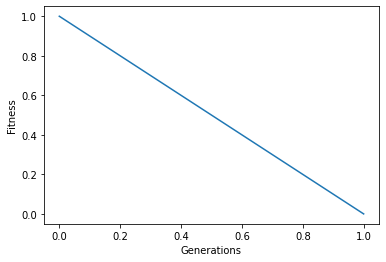

In [288]:
a = Evolution(n_size = 8)
a.evolve()
a.plot_fitness_list()

In [277]:
a.get_best_fitness()

0

In [278]:
a.generation

12

In [279]:
a.print_board()

['_' '_' '_' 'Q' '_' '_' '_' '_']
['_' '_' '_' '_' '_' '_' '_' 'Q']
['Q' '_' '_' '_' '_' '_' '_' '_']
['_' '_' '_' '_' 'Q' '_' '_' '_']
['_' '_' '_' '_' '_' '_' 'Q' '_']
['_' 'Q' '_' '_' '_' '_' '_' '_']
['_' '_' '_' '_' '_' 'Q' '_' '_']
['_' '_' 'Q' '_' '_' '_' '_' '_']


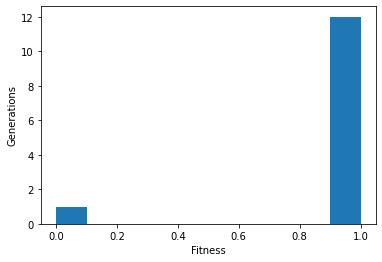

In [280]:
a.plot_histogram()